In [ ]:
# import necessary libraries
from img_util import ImageDataLoader as IDL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import pandas as pd

import numpy as np
from skimage.measure import label
from scipy.ndimage import binary_dilation, generate_binary_structure
def count_connected_components(mask) -> int:
    """Counts the number of connected components in the given binary mask.
    
    :param mask: The binary mask to be analyzed
    :return: The number of connected components in the mask
    
    """

    # create cross-shaped structure to dilate
    structure = generate_binary_structure(mask.ndim, 1)

    # dilate mask to close small gaps
    cc_list = []

    # dilate an increasing amount of times, save n. of cc for each iteration.
    # necessary since some masks do not behave as expected (potentially invisible
    # gaps make the number of cc skyroket, this prevents that, or at least provides
    # a more accurate estimate)
    for i in range(5, 26, 5):
        dilated_mask = binary_dilation(mask, structure= structure, iterations= i)

        # label mask
        labeled_mask = label(dilated_mask, connectivity= 2)

        # find number of cc: label() assigns an integer to
        # each cc, so the max value will be the total n of ccs.
        cc = labeled_mask.max()
        
        # append result
        cc_list.append(cc)
    
    # return mean cc number
    return sum(cc_list) // len(cc_list)

# import necessary libraries
import numpy as np
import cv2

def fBV_extractor(image, mask) -> float:
    """Computes the percentage of the lesion in the given (RGB) image
    that consists of blue / purple-ish pixels (blue veils).
    It outputs a value between 0 and 1, where a 0 indicates total 
    absence of blue veils, and a 1 indicates that the lesion is
    completely covered in blue veils.
    
    :param image: The RGB image to be analysed
    :param mask: The mask for the given image
    :return: Float with value between 0 and 1
    
    """

    # store n. of pixels in the mask
    tot_pixels = np.count_nonzero(mask)

    # convert image to HSV and apply mask
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # make the mask 3D
    mask_3D = mask[:, :, np.newaxis]
    
    # resize the image to make SURE it matches with the mask
    mask_height = mask_3D.shape[0]
    mask_width = mask_3D.shape[1]

    image_hsv = cv2.resize(image_hsv, (mask_width, mask_height))

    # apply mask
    image_hsv = image_hsv * mask_3D

    # extract H channel
    h = image_hsv[:, :, 0]

    # create mask to filter out all pixels that are not blue / purple-ish
    bp_mask = (h >= 100) & (h <= 145)
    # Note: H is in degrees, but in cv2 its range is not 0-360 but 0-179, so we halve the values

    bp_mask_3D = bp_mask[:, :, np.newaxis]
    # Note: H is in degrees, but in cv2 its range is not 0-360 but 0-179, so we halve the values

    # TEST PURPOSES
    test_img = image_hsv * bp_mask_3D
    test_img = cv2.cvtColor(test_img, cv2.COLOR_HSV2RGB)

    # store n. of blue / purple pixels
    veil_pixels = np.count_nonzero(bp_mask)

    # compute portion of lesion covered by blue veils
    BV = veil_pixels / tot_pixels
    # value from 0 to 1: from no blue veils to entirely covered in blue veils

    return test_img, BV

In [14]:
# set up relevant directories
img_dir = '../data/lesion_imgs/'
mask_dir = '../data/lesion_masks/'

metadata_dir = "../data/metadata.csv"

# read the relevant csv files
md = pd.read_csv(metadata_dir)
# load up the images and relative masks
data_loader = IDL(img_dir, mask_dir)

data_iterator = iter(data_loader)

In [12]:
# skip random n of images
n = random.randint(0, 2000)
print(n)
for _ in range(n):
    next(data_iterator)

1017


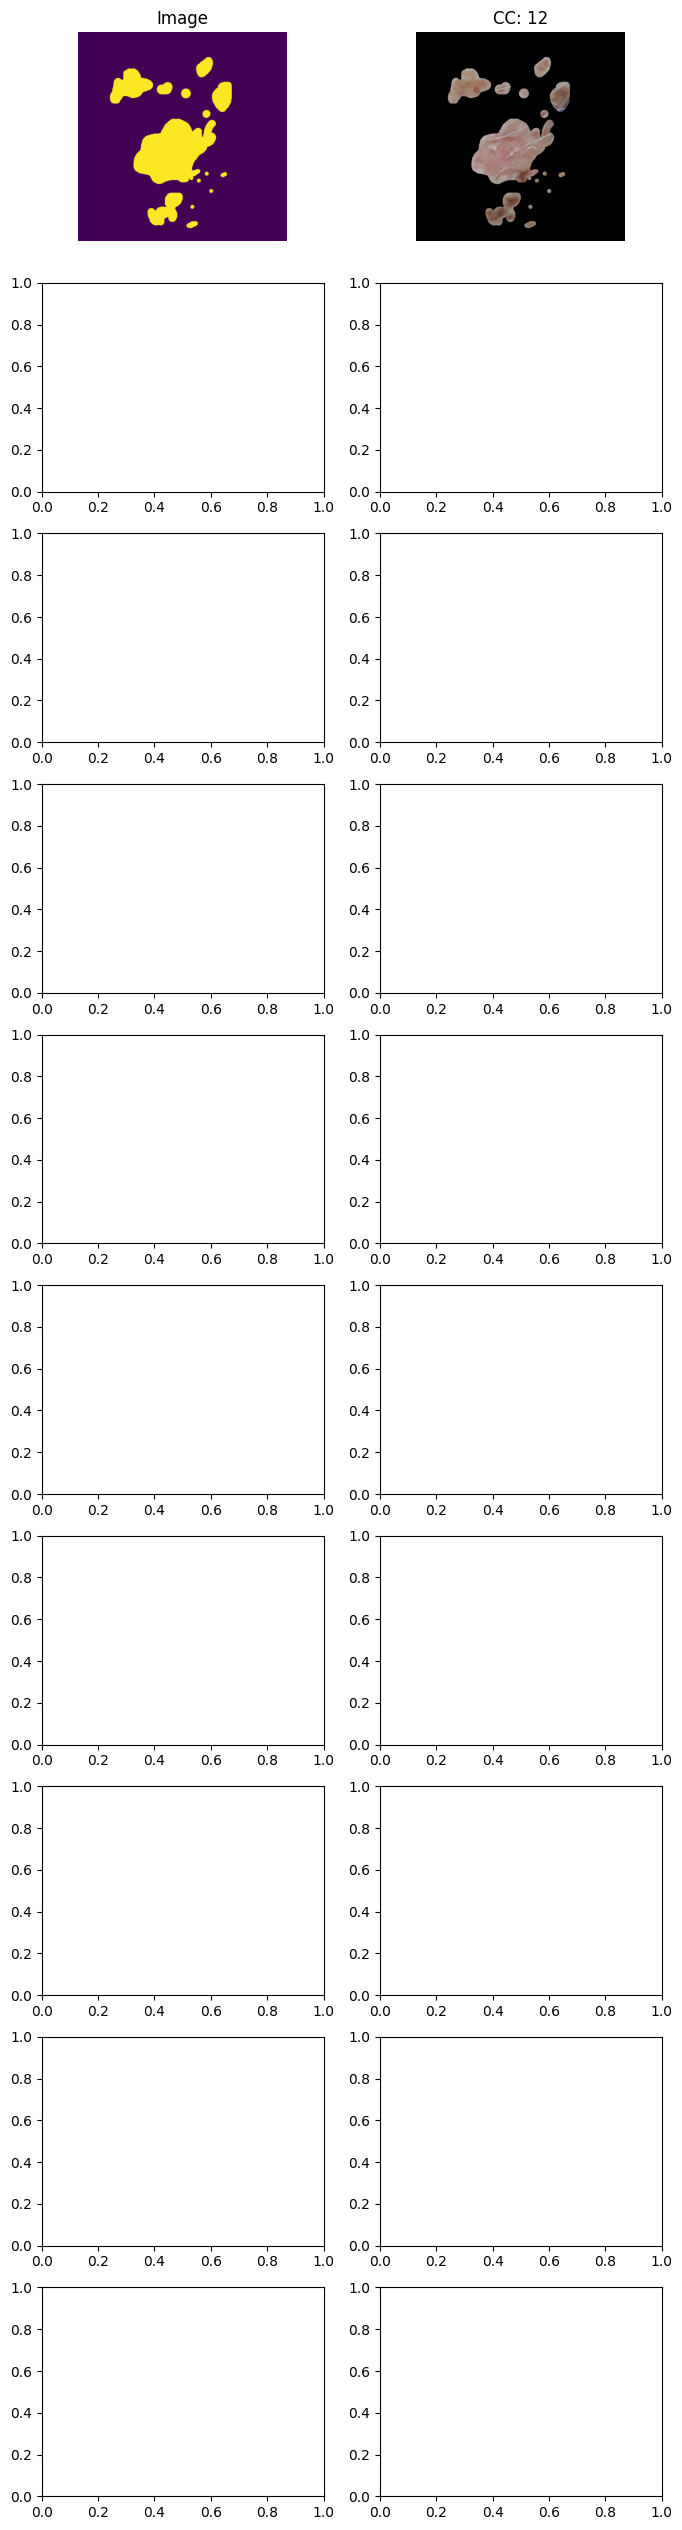

In [3]:
# plot 10 random imgs

fig, axes = plt.subplots(10, 2, figsize= (8, 32))

for i in range(1):
    mask = cv2.imread("../data/lesion_masks/PAT_207_3951_140_mask.png")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.imread("../data/lesion_imgs/PAT_207_3951_140.png")
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    cc = count_connected_components(mask)

    img_rgb[mask == 0] = [0, 0, 0]

    axes[i, 0].imshow(mask)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image")

    axes[i, 1].imshow(img_rgb)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"CC: {cc}")

plt.show()


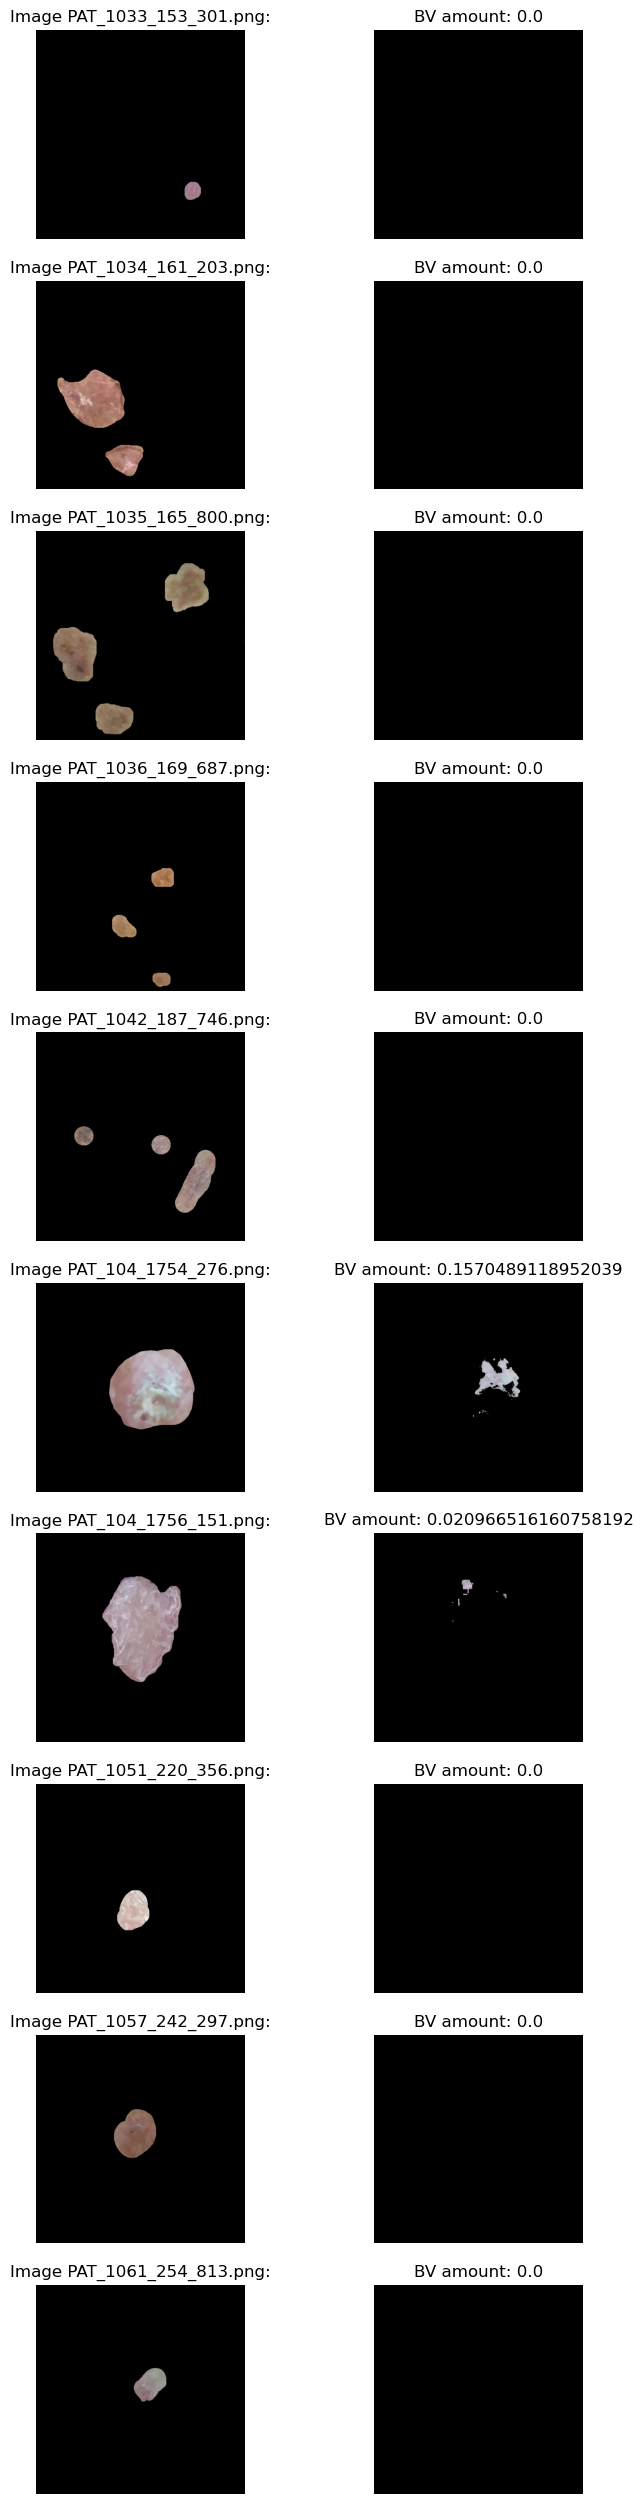

In [113]:
# plot 10 random imgs

fig, axes = plt.subplots(10, 2, figsize= (8, 32))

for i in range(10):
    img_rgb, img_gray, mask, mask_og, name = next(data_iterator)

    test_img, BV = fBV_extractor(img_rgb, mask)

    img_rgb[mask == 0] = [0, 0, 0]

    axes[i, 0].imshow(img_rgb)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Image {name}:")

    axes[i, 1].imshow(test_img)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"BV amount: {BV}")

plt.show()